# Regression loss (MAE vs MSE)





### Dataset

We use [Concrete Compressive Strength Data Set](<http://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength>) to compare various losses we can use for regression. In this notebook, we are primarily looking at (MAE vs MSE). For other losses, you can refer to this .[link] (https://keras.io/api/losses/regression_losses/)

The input values $X$ are columns 1-8, representing the various compositions of concrete. The target values $y$ are the compressive strengths in the last column, which is a function of the input compositions.

$$ y = f(X) $$

Our goal is to **approximate** this function $f(.)$ by some function $\hat{f}(\cdot,\theta)$, and then learn $\theta$ using data.



### Python Libraries

Load required python libraries



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_excel('./data/Concrete_Data.xls', sheet_name='Sheet1')


In [2]:
df_cols=['Cement [kg/m3]', # get column names for indexing later
         'Blast Furnace Slag [kg/m3]',
         'Fly Ash [kg/m3]',
         'Water [kg/m3]',
         'Superplasticizer [kg/m3]',
         'Coarse Aggregate [kg/m3]',
         'Fine Aggregate [kg/m3]',
         'Age [day]',
         'Compressive Strength [MPa]']
df.columns = df_cols

### Regression model
Let's build a regression model to predict compressive strength based on the 7 input features

Split the dataset into training and test sets

In [3]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y= df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2 )

### linear regression
Let us try to fit the function using a simple linear regression model

In [4]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)  # Training set predictions
y_hat_test = regressor.predict(X_test)  # Test set predictions

We can use matplotlib to visualize the prediction vs ground truth

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def plot_predictions(y, y_hat, labels):
 
  
    plt.rcParams.update({'font.size': 18, 'font.sans-serif':'arial'})
    y, y_hat, labels = list(
        map(
            lambda l: l if isinstance(l, list) else [l],
            [y, y_hat, labels]))
    color_list = ['blue', 'red']
    n_plots = len(y)
    y_min = min([min(z) for z in y])
    y_max = max([max(z) for z in y])
    lims = (y_min, y_max)
    fig, ax = plt.subplots(
        1, n_plots, figsize=(7*n_plots, 6),
        squeeze=False, sharex=True, sharey=True)
    for axis, target, prediction, label, color in zip(ax[0, :], y, y_hat, labels, color_list):
        # Scatter plot
        axis.scatter(target, prediction, alpha=0.3, c = color)

        # Title and labels
        rmse_value = np.sqrt(mean_squared_error(target, prediction))
        mae_value = mean_absolute_error (target, prediction)
        title = label + " (RMSE=%.3f" % rmse_value +" ,MAE=%.3f)" % mae_value
        axis.set_title(title)
        axis.set_xlabel('Target Compressive Strength (MPa)')
        axis.set_ylabel('Predicted Compressive Strength (MPa)')
        axis.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        axis.yaxis.set_tick_params(which='both', labelleft=True)

    plt.subplots_adjust(wspace = 0.3)
    plt.show()


We can generate the same plot with one line of code

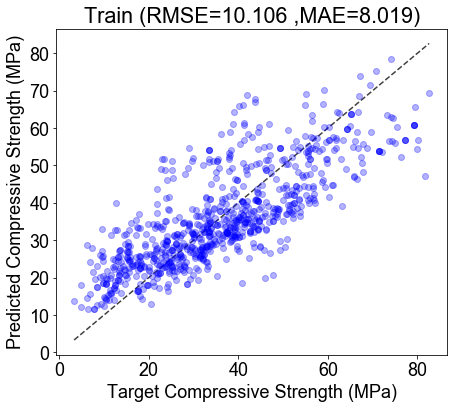

In [6]:
plot_predictions(y_train, y_hat_train,    labels=['Train'])

### Polynomial regression
Let us fit the 8 input variable using a 3 order polynomial regression


In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree=3
regressor=make_pipeline(PolynomialFeatures(degree),LinearRegression())
regressor.fit(X,y)

regressor.fit(X_train, y_train)


y_hat_train = regressor.predict(X_train)  # Training set predictions
y_hat_test = regressor.predict(X_test)  # Test set predictions

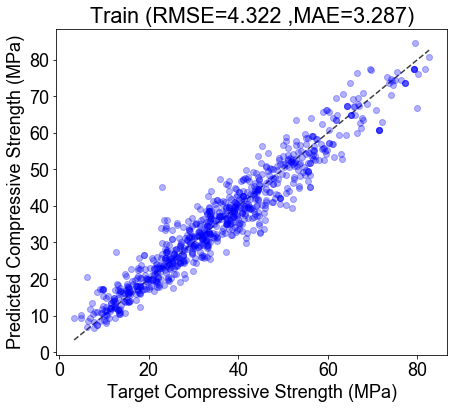

In [8]:
plot_predictions(y_train, y_hat_train,    labels=['Train'])

## Impact of outliers 

Now we introduce a few outliers in our training dataset

In [9]:
y_train_out = np.copy(y_train)
y_train_out[:10] = y_train_out[:10] +100


Let us repeat the same procedure to train the regression models

### Linear regression with outliers

In [10]:
from sklearn.linear_model import LinearRegression

regressor_out = LinearRegression()
regressor_out.fit(X_train, y_train_out)

y_hat_train_out = regressor_out.predict(X_train)  # Training set predictions
y_hat_test_out = regressor_out.predict(X_test)  # Test set predictions

We can take a look at the change in RMSE and MAE values with outliers and data without outliers. The plot with outliers uses the same regression model but excludes the outliers in computing MAE and RMSE values.

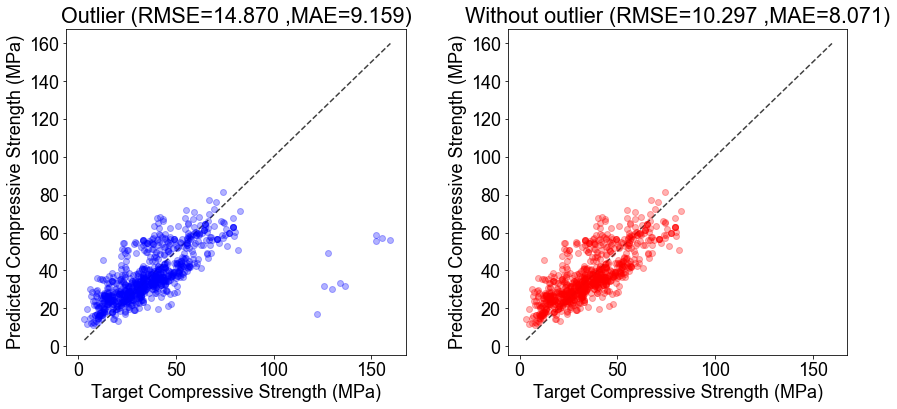

In [11]:
plot_predictions([y_train_out, y_train_out[10:]], [y_hat_train_out,y_hat_train_out[10:]] ,   labels=['Outlier', 'Without outlier'])

### Polynomial regression with outliers

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree=3
regressor_out=make_pipeline(PolynomialFeatures(degree),LinearRegression())
regressor_out.fit(X,y)

regressor_out.fit(X_train, y_train_out)


y_hat_train_out = regressor_out.predict(X_train)  # Training set predictions
y_hat_test_out = regressor_out.predict(X_test)  # Test set predictions

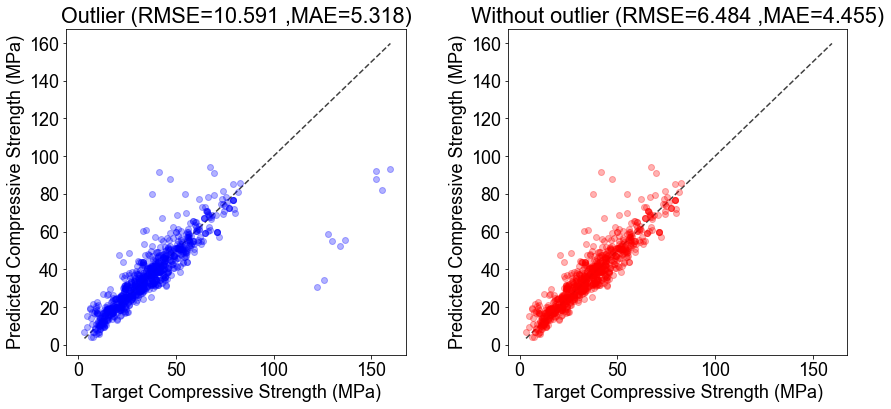

In [13]:
plot_predictions([y_train_out, y_train_out[10:]], [y_hat_train_out,y_hat_train_out[10:]] ,   labels=['Outlier', 'Without outlier'])

### Plotting the differences between MSE, MAE and PMAE

We can visualize MSE, MAE and PMAE to understand their differences

Instead of using the function form scikit-learn, we first define those loss functions

In [14]:
def mse(target, prediction): 

    return np.sum((target - prediction)**2)

In [15]:
def mae(target, prediction): 

    return np.sum(np.abs(target - prediction))

In [16]:
def pmae(target, prediction): 

    return np.sum(np.abs(target - prediction)/np.abs(target))

Create some dummy variables to compute those losses

In [19]:
target = np.repeat(0.5, 1000) 
pred = np.arange(-10,10, 0.02)

# calculating loss function for all predictions. 
loss_mse = [mse(target[i], pred[i]) for i in range(len(pred))]
loss_mae = [mae(target[i], pred[i]) for i in range(len(pred))]
loss_pmae = [pmae(target[i], pred[i]) for i in range(len(pred))]

Use matplotlib to visualize the differences

(0, 50)

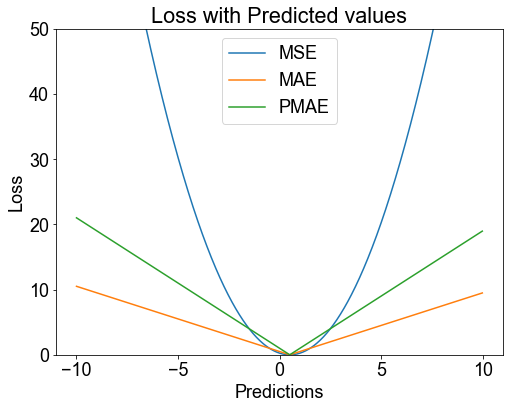

In [21]:
fig = plt.figure (figsize=(8,6))
losses = [loss_mse, loss_mae, loss_pmae]
names = ['MSE', 'MAE','PMAE' ]


for i in range(len(losses)):
    plt.plot(pred, losses[i], label = names[i])
plt.xlabel('Predictions')
plt.ylabel('Loss')
plt.title("Loss with Predicted values")
plt.legend()
plt.ylim(0,50)